# Evaluate simulated community classification accuracy
The purpose of this notebook is to evaluate taxonomic classification accuracy of simulated communities using different classification methods.

Prepare the environment
-----------------------

First we'll import various functions that we'll need for generating the report. 

In [1]:
%matplotlib inline
from os.path import join, exists, expandvars
import pandas as pd
from IPython.display import display
from tax_credit.plotting_functions import (pointplot_from_data_frame,
                                           boxplot_from_data_frame,
                                           heatmap_from_data_frame,
                                           per_level_kruskal_wallis,
                                           beta_diversity_pcoa,
                                           average_distance_boxplots,
                                           rank_optimized_method_performance_by_dataset)
from tax_credit.eval_framework import (evaluate_results,
                                       method_by_dataset_a1,
                                       method_by_dataset_a2,
                                       parameter_comparisons,
                                       merge_expected_and_observed_tables)

Configure local environment-specific values
-------------------------------------------

**This is the only cell that you will need to edit to generate basic reports locally.** After editing this cell, you can run all cells in this notebook to generate your analysis report. This will take a few minutes to run, as results are computed at multiple taxonomic levels.

Values in this cell will not need to be changed, with the exception of ``project_dir``, to generate the default results contained within tax-credit. To analyze results separately from the tax-credit precomputed results, other variables in this cell will need to be set.

In [2]:
## project_dir should be the directory where you've downloaded (or cloned) the 
## tax-credit repository. 
project_dir = expandvars("../../")

## expected_results_dir contains expected composition data in the structure
## expected_results_dir/<dataset name>/<reference name>/expected/
expected_results_dir = join(project_dir, "data/precomputed-results/simulated-community")

## simulated_results_fp designates the files to which summary results are written.
## If this file exists, it can be read in to generate results plots, instead
## of computing new scores.
simulated_results_fp = join(expected_results_dir, 'simulated_results.tsv')

## results_dirs should contain the directory or directories where
## results can be found. By default, this is the same location as expected.
results_dirs = [expected_results_dir]

## Minimum number of times an OTU must be observed for it to be included in analyses. Edit this
## to analyze the effect of the minimum count on taxonomic results.
min_count = 1

## Define the range of taxonomic levels over which to compute accuracy scores.
## The default given below will compute order (level 2) through species (level 6)
taxonomy_level_range = range(2,7)

Find simulated community pre-computed tables, expected tables, and "query" tables
----------------------------------------------------------------------------

Next we'll use the paths defined above to find all of the tables that will be compared. These include the *pre-computed result* tables (i.e., the ones that the new methods will be compared to), the *expected result* tables (i.e., the tables containing the known composition of the simulated microbial communities), and the *query result* tables (i.e., the tables generated with the new method(s) that we want to compare to the *pre-computed result* tables).

**Note**: if you have added additional methods and are attempting to recompute results, set force=True.

This cell will take a few minutes to run, so hold onto your hat.

In [3]:
mock_results = evaluate_results(results_dirs, 
                                expected_results_dir, 
                                simulated_results_fp, 
                                taxonomy_level_range=range(2,7), 
                                min_count=min_count,
                                taxa_to_keep=None, 
                                md_key='taxonomy', 
                                subsample=False,
                                filename_pattern='expected-composition.biom',
                                force=False)

/Users/nbokulich/Desktop/projects/tax-credit/data/precomputed-results/simulated-community/simulated_results.tsv already exists.
Reading in pre-computed evaluation results.
To overwrite, set force=True


Restrict analyses to a set of datasets or references: e.g., exclude taxonomy assignments made for purpose of reference database comparisons.

In [4]:
mock_results = mock_results[mock_results['Reference'].isin(['gg_13_8_otus', 'unite_20.11.2016'])]

Evalution 1: Compute and summarize precision, recall, and F-measure for mock communities
----------------------------------------------------------------------------------------

In this evaluation, we compute and summarize precision, recall, and F-measure of each result (pre-computed and query) based on the known composition of the mock communities. We then summarize the results in two ways: first with boxplots, and second with a table of the top methods based on their F-measures. 

This is a qualitative evaluation, effectively telling us about the ability of the different methods to report the taxa that are present in each sample. These metrics are not concerned with the abundance of the different taxa.

As a first step, we will evaluate how accuracy metrics perform at each taxonomic level for each method within each reference dataset type.

In [5]:
color_pallette={'expected': 'red', 'rdp': 'seagreen', 'sortmerna': 'gray', 'uclust': 'blue', 'blast': 'purple'}

y_vars = ["Precision", "Recall", "F-measure"]

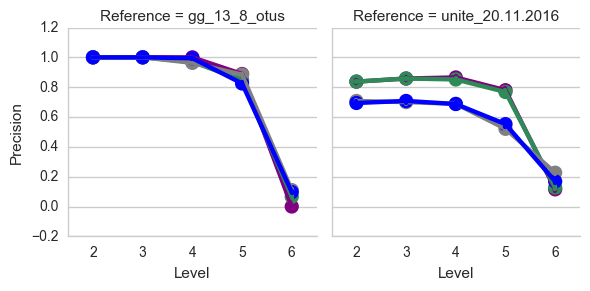

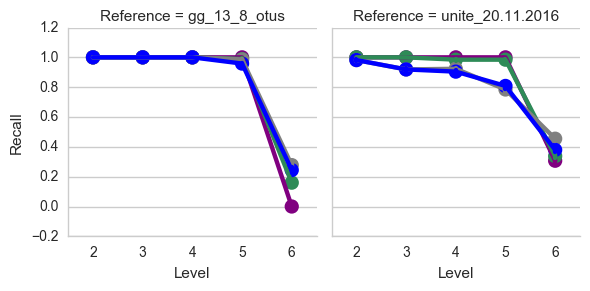

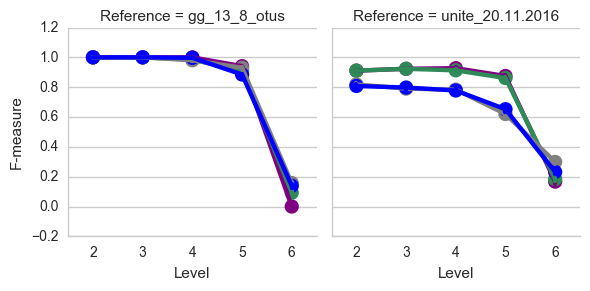

In [87]:
pointplot_from_data_frame(mock_results, "Level", y_vars, 
                          group_by="Reference", color_by="Method",
                          color_pallette=color_pallette)

### Kruskal-Wallis between-method accuracy comparisons
Kruskal-Wallis FDR-corrected p-values comparing classification methods at each level of taxonomic assignment

In [88]:
result = per_level_kruskal_wallis(mock_results, y_vars, group_by='Method', 
                                  dataset_col='Reference', level_name='Level',
                                  levelrange=range(2,7), alpha=0.05, 
                                  pval_correction='fdr_bh')
result

,Reference,Variable,2,3,4,5,6
0,gg_13_8_otus,Precision,1.000000e+00,1.000000e+00,3.630454e-43,8.617203e-38,7.634303e-45
1,gg_13_8_otus,Recall,1.000000e+00,1.000000e+00,1.000000e+00,1.318286e-38,1.991463e-43
2,gg_13_8_otus,F-measure,1.000000e+00,1.000000e+00,3.630454e-43,3.194770e-38,3.797269e-45
3,unite_20.11.2016,Precision,1.202140e-59,7.122758e-59,3.106905e-52,1.212550e-51,4.041241e-42
4,unite_20.11.2016,Recall,1.206363e-04,8.444509e-36,3.700383e-31,8.617203e-38,2.228590e-22
5,unite_20.11.2016,F-measure,1.206722e-59,7.122758e-59,2.731260e-51,4.836259e-51,3.184183e-37


### Beta diversity method/parameter comparisons
Principal coordinate analysis offers a neat way to assess the relative performance of multiple methods to reconstruct expected compositions. Methods that cluster with the "expected" composition probably outperform those that appear more distant on a PCoA plot. First, we need to merge biom tables from each method/parameter configuration for each dataset/reference/level combination, so that we can compare each method/parameter as a separate "sample".

__*Note: if you have added additional methods and are attempting to recompute results, set force=True.*__


In [89]:
merge_expected_and_observed_tables(expected_results_dir, results_dirs, taxonomy_level=6, 
                                   filename_pattern='expected-composition.biom', force=False)

Now we can manually select which table we want to view. This will output a Bray-Curtis PCoA plot, in addition to ANOSIM test results, which indicate whether at least two methods are significantly different from each other.

These plots are useful for visualizing the relative performance of different methods and their configurations relative to each other and to expected compositions, but are primarily a qualitative technique and do not really give us an idea of whether method X actually performs better than method Y.

__*Note that 2D plots will only appear if you are running notebooks locally. If viewing static notebooks online, make sure you are viewing this notebook in [nbviewer](http://nbviewer.jupyter.org/). (if viewing on GitHub, just copy the URL and paste into the search bar in nbviewer.)*__

In [6]:
table = join(expected_results_dir, 'sake', 'gg_13_8_otus', 'merged_table.biom')
sample_md, results, pc, dm = beta_diversity_pcoa(table, method="braycurtis", dim=2,
                                                 permutations=99, col='method', 
                                                 colormap=color_pallette)

/Users/nbokulich/miniconda3/envs/qiime2-06/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -9.638367865616413 and the largest is 139.55948626902403.
  RuntimeWarning


R =  0.0705107564983 ; P =  0.01


Loading BokehJS ...

In [7]:
table = join(expected_results_dir, 'wine', 'unite_20.11.2016', 'merged_table.biom')
sample_md, results, pc, dm = beta_diversity_pcoa(table, method="braycurtis", dim=2,
                                                 permutations=99, col='method', 
                                                 colormap=color_pallette)

/Users/nbokulich/miniconda3/envs/qiime2-06/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -4.330454414739377 and the largest is 149.67042272885453.
  RuntimeWarning


R =  0.0490377978984 ; P =  0.01


Loading BokehJS ...

Let's generate more Bray-Curtis distance plots at genus level. Unlike the species-level plots, in which samples cluster primarily by method configuration, and some method configurations perform considerably better than others, we see at genus level that samples cluster instead according to sample type with less regard to method configuration, indicating that most method configurations perform well at genus level, but few perform well at species level.

In [91]:
merge_expected_and_observed_tables(expected_results_dir, results_dirs, taxonomy_level=5, 
                                   filename_pattern='expected-composition.biom', force=False,
                                   biom_fp='merged_table_L5.biom')

In [8]:
table = join(expected_results_dir, 'sake', 'gg_13_8_otus', 'merged_table_L5.biom')
sample_md, results, pc, dm = beta_diversity_pcoa(table, method="braycurtis", dim=2,
                                                 permutations=99, col='method', 
                                                 colormap=color_pallette)

/Users/nbokulich/miniconda3/envs/qiime2-06/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -6.068156001278058 and the largest is 153.82229581215245.
  RuntimeWarning


R =  0.0272653620448 ; P =  0.01


Loading BokehJS ...

In [9]:
table = join(expected_results_dir, 'wine', 'unite_20.11.2016', 'merged_table_L5.biom')
sample_md, results, pc, dm = beta_diversity_pcoa(table, method="braycurtis", dim=2,
                                                 permutations=99, col='method', 
                                                 colormap=color_pallette)

/Users/nbokulich/miniconda3/envs/qiime2-06/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -5.839811696307641 and the largest is 140.56334390574816.
  RuntimeWarning


R =  0.0274301418057 ; P =  0.01


Loading BokehJS ...

### Average distance between expected results and observed results for each method 
Generates violin plots of distribution of distances between expected composition and predicted compositions for each method (all parameter configurations) across all samples/datasets, and pairwise Mann Whitney U tests between these distributions.

,method A,method B,P
0,blast,rdp,5.010659e-12
1,blast,sortmerna,0.000000e+00
2,blast,uclust,0.000000e+00
3,rdp,sortmerna,6.191701e-01
4,rdp,uclust,7.404166e-03
5,sortmerna,uclust,6.017053e-04


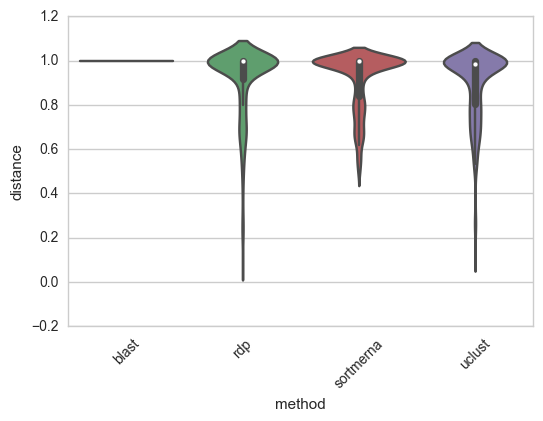

In [64]:
results = average_distance_boxplots(expected_results_dir, paired=False, use_best=False)
results

### Average distance between expected results and observed results for each method with optimized parameters 
Reports the top-performing parameter configuration for each method, violin plots of distribution of distances between expected composition and predicted compositions for the top parameter for each method across all samples/datasets, and pairwise paired Wilcoxon signed rank tests between these distributions.

,method,params
0,blast,0.001
1,rdp,1.0
2,sortmerna,1.0:0.8:5:0.9:1.0
3,uclust,1.0:0.8:5


,method A,method B,P
0,blast,rdp,2.623841e-09
1,blast,sortmerna,5.066436e-09
2,blast,uclust,4.259926e-12
3,rdp,sortmerna,4.176882e-06
4,rdp,uclust,5.778344e-04
5,sortmerna,uclust,1.795127e-02


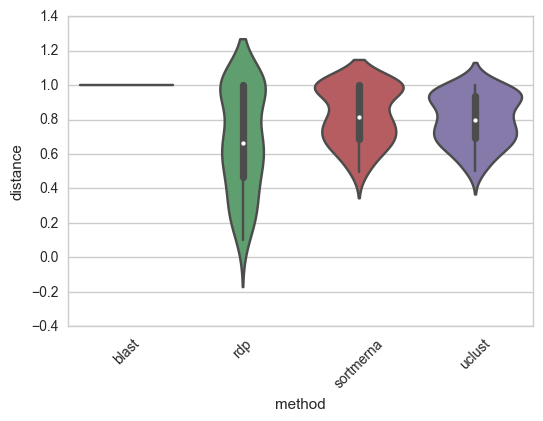

In [65]:
results = average_distance_boxplots(expected_results_dir)
results

### Method Optimization
Which method/parameter configuration performed "best" for a given score? We can rank the top-performing configuration by dataset, method, and taxonomic level.

First, the top-performing method/configuration combination by dataset.

In [68]:
mock_results_6 = mock_results[mock_results['Level'] == 6]

In [73]:
for i in mock_results_6['Dataset'].unique():
    print(i)
    best = method_by_dataset_a1(mock_results_6, i)
    display(best)

sake


,Method,Parameters,Precision,Recall,F-measure
10664,uclust,1.0:0.9:5,0.294118,0.714286,0.416667
6962,sortmerna,1.0:0.8:5:0.9:1.0,0.263158,0.625000,0.370370
2294,rdp,1.0,0.250000,0.428571,0.315789
124,blast,0.001,0.000000,0.000000,0.000000


wine


,Method,Parameters,Precision,Recall,F-measure
15281,uclust,0.51:0.8:5,0.333333,0.571429,0.421053
11798,rdp,0.8,0.187500,0.428571,0.260870
12215,sortmerna,0.51:0.8:3:0.8:1.0,0.153846,0.400000,0.222222
10763,blast,0.001,0.000000,0.000000,0.000000


Now we can determine which parameter configuration performed best for each method. *Count best* values in each column indicate how many samples a given method achieved within one mean absolute deviation of the best result (which is why they may sum to more than the total number of samples).

In [74]:
for method in mock_results_6['Method'].unique():
    top_params = parameter_comparisons(mock_results_6, method)
    print(method)
    display(top_params[:5])

blast


,F-measure,Pearson r,Precision,Recall,Spearman r
0.001,48,48,48,48,48
1,48,48,48,48,48
1000,48,48,48,48,48
1e-10,48,48,48,48,48


rdp


,F-measure,Pearson r,Precision,Recall,Spearman r
1.0,31.0,32,31.0,31.0,31.0
0.9,31.0,17,30.0,31.0,30.0
0.7,47.0,13,17.0,48.0,22.0
0.6,17.0,14,17.0,48.0,19.0
0.8,17.0,14,17.0,48.0,17.0


sortmerna


,F-measure,Pearson r,Precision,Recall,Spearman r
1.0:0.9:5:0.9:1.0,32,31,32,32,32.0
1.0:0.9:3:0.9:1.0,32,31,32,32,32.0
0.76:0.9:3:0.8:1.0,32,31,32,32,32.0
0.76:0.8:3:0.9:1.0,39,34,39,39,32.0
0.76:0.8:3:0.8:1.0,39,34,39,39,32.0


uclust


,F-measure,Pearson r,Precision,Recall,Spearman r
1.0:0.8:5,38.0,33,38.0,38.0,32.0
1.0:0.9:5,31.0,30,31.0,31.0,31.0
1.0:0.9:3,31.0,31,31.0,31.0,31.0
0.76:0.9:3,31.0,31,31.0,31.0,31.0
0.76:0.8:3,7.0,33,7.0,7.0,26.0
